<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/Seq2Seq/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries:
!pip install transformers datasets sentencepiece
# `transformers` library: for using pre-trained models
# `datasets` library: to access a collection of high-quality datasets for NLP tasks
# `sentencepiece` library: to tokenize text into subwords

# Load the dataset & split it into training and testing sets:

The process of loading a dataset might implicitly involve downloading it if the dataset is not already present on your system.

In [2]:
from datasets import load_dataset # from the library, import the function

# [Reference] possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="fr") # load a dataset named "kde4" with specific language configurations
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

👆 Too many samples!

In [3]:
small = data["train"].shuffle(seed=42).select(range(1_000)) # create a smaller, shuffled subset of the training data
# .shuffle(): this method shuffles the training examples
# seed=42: the seed parameter is set to 42 to ensure reproducibility
# .select(range(1_000)): selects the first 20,000 examples (0-999)
small

Dataset({
    features: ['id', 'translation'],
    num_rows: 1000
})

In [4]:
# split dataset ('small') into training and testing sets:
split = small.train_test_split(seed=42) # ensure the split is reproducible
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [5]:
# check the 1st example from the training set:
split["train"][0]

{'id': '169005',
 'translation': {'en': '& Reduce Tree', 'fr': "& Refermer l' arborescence"}}

# Load the tokenizer:

In [6]:
from transformers import AutoTokenizer # import the class, enabling dynamic loading of tokenizer for a specific pre-trained model

checkpoint = "Helsinki-NLP/opus-mt-en-fr" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# Prepare the model inputs:

In [7]:
# check the 6th example from the training set:
split["train"][5]

{'id': '46472',
 'translation': {'en': 'You can either pick a file or enter its name in the Location: box.',
  'fr': 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.'}}

In [8]:
# extract the English and French translation texts from the 6th example (idx=5):
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('You can either pick a file or enter its name in the Location: box.',
 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.')

In [9]:
# tokenize the English translation text -> the input tokens (into a machine learning model)
inputs = tokenizer(en)
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 Note: it comes with an attention mask

In [10]:
# tokenize the French translation text -> the target tokens
targets = tokenizer(text_target=fr) # NOTE: must specify `text_target` here!
targets

{'input_ids': [344, 1069, 345, 4094, 34, 2428, 345, 9315, 113, 689, 31, 8, 1283, 5, 1470, 21708, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

👆 `targets` is a dictionary obtained from tokenizing some text,

and 'input_ids' is a key in this dictionary.

The value associated with this key is **a sequence of token IDs**.

In [11]:
# just for checking purpose, convert ids back into string tokens:
# the `convert_ids_to_tokens` method is a functionality provided by `tokenizer`
# it takes a sequence of token ids & returns the corresponding tokens in a human-readable format
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

Matches the print out in line 10 🎉

one word -> one string token ✅

In [12]:
# (wrong) demo: What will happen if we didn't specify `text_target` in line 21?
bad_targets = tokenizer(fr) # should be `targets = tokenizer(text_target=fr)` instead
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁V',
 'ous',
 '▁po',
 'uv',
 'ez',
 '▁so',
 'it',
 '▁cho',
 'is',
 'ir',
 '▁un',
 '▁fi',
 'chi',
 'er',
 '▁so',
 'it',
 '▁s',
 'ais',
 'ir',
 '▁son',
 '▁no',
 'm',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁text',
 'e',
 '▁Em',
 'placement',
 '.',
 '</s>']

👆 Not completely fail.

However, one word -> multiple string tokens ❌

In [13]:
import matplotlib.pyplot as plt # from the matplotlib library, import the pyplot module for data visualization

In [14]:
# scratch:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [15]:
# scratch:
split['train']['translation'][9]

{'en': 'Creating new Data CD Project.',
 'fr': "Création d'un nouveau projet de CD de données."}

In [16]:
# retrieve 'translation' features of the training subset:
train = split['train']['translation']

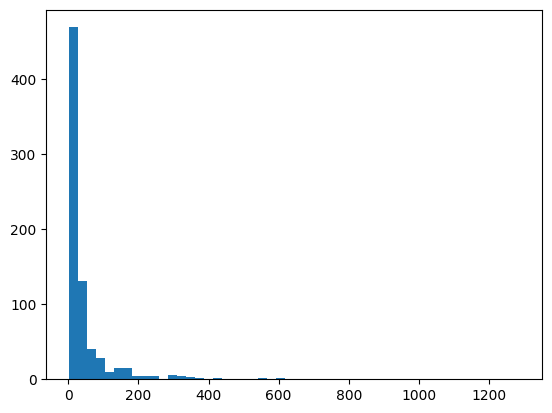

In [17]:
# histogram to check the (English) input lengths:
input_lens = [len(tr['en']) for tr in train]
plt.hist(input_lens, bins=50);  # `;` suppresses output of the last expression

👆 The majority of input lengths fall below 100.

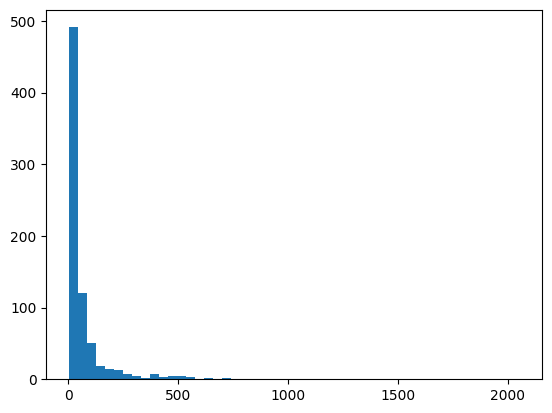

In [18]:
# histogram to check the (French) target lengths:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

👆 The majority of target lengths fall below 150.

# Tokenizer function:

In [19]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  # tokenize the inputs:
  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)
  print(tokenized_inputs)

  # tokenize the targets:
  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
  print(tokenized_targets)

  tokenized_inputs['labels'] = tokenized_targets['input_ids'] # ignore attention masks
  return tokenized_inputs

# Apply the tokenizer:

In [20]:
# apply a function (`tokenizer_fn`) to each example in the dataset (`split`) & save as a new dataset (`tokenized_datasets`):
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True, # apply tokenization function to examples in batches rather than individually
    remove_columns=split['train'].column_names, # specify the columns to be removed from the resulting tokenized dataset
)

# Load the pretrained model:

In [21]:
from transformers import AutoModelForSeq2SeqLM # a class for loading pre-trained sequence-to-sequence language model

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint) # load a pre-trained model specified by the `checkpoint`

# Data collator:

A component that processes and organizes input data before feeding it into a model for training or evaluation.
*   Batch creation
*   Padding (per batch)
*   Handling special tokens
*   Converting data to torch tensors

In [22]:
from transformers import DataCollatorForSeq2Seq # a class for combining a batch of examples into a format suitable for training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # create an instance of the class for sequence-to-sequence tasks
# the tokenizer used to process the input and output data
# the model that will be used

In [23]:
# check some tokenized training data:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

👆 It's a list of dictionaries.

Each dict corresponds to a sample.

And each sample consists 3 fields (input_ids, attention_mask, labels).

In [24]:
# test the data collator on the above inputs:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

👆 4 fields now (field 'decoder_input_ids' was added)

'decoder_input_ids' is the input for the decoder

👆 Great, they are tensors!

In [25]:
# check the 'decoder_input_ids' field of the collated batch:
batch["decoder_input_ids"]

tensor([[59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [59513, 34023,     5,  3948,     5,   372,   402, 38492,   350,   823,
            95, 13439,     2, 25985,    14,     6,  3996,     3]])

👆 59513 is a special token. It's both the ***start token*** and the ***padding token*** for each sentence

In [26]:
# decoder input IDs -> human-readable tokens:
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁K',
 'DE',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [27]:
# check the 'labels' field of the collated batch:
batch["labels"]

tensor([[  526,  3261,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [34023,     5,  3948,     5,   372,   402, 38492,   350,   823,    95,
         13439,     2, 25985,    14,     6,  3996,     3,     0]])

👆 Again, each sentence had 59513 padding tokens ***added to both the beginning and the end***.

In [28]:
# token IDs -> human-readable tokens:
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁K',
 'DE',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

👆 The targets are just a shifted version of the decoder inputs.

`'<unk>'` for unknown

In [29]:
split['train'][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

# Translation metrics:

In [30]:
# install packages:
!pip install sacrebleu bert-score
# sacrebleu is focused on the BLEU metric for translation evaluation
# bert-score provides evaluation metrics using contextual embeddings, particularly BERT embeddings

In [31]:
from datasets import load_metric # a library to load evaluation metrics

bleu_metric = load_metric("sacrebleu") # load metrics for evaluating translation outputs based on the BLEU metric
bert_metric = load_metric("bertscore") # load metrics for evaluating text generation outputs using BERT embeddings

<ipython-input-31-ea55910897b9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu") # load metrics for evaluating translation outputs based on the BLEU metric


In [32]:
# dummy test for a short sentence:
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])
# Note: references/targets must be in a list. Because for BLEU, there can be multiple acceptable reference translations.

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [33]:
# dummy test for a longer sentence:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [34]:
# compute BERTScore for a set of predictions and their corresponding references:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en') # 'like' vs 'love'

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803369045257568],
 'recall': [0.9803369045257568],
 'f1': [0.9803369045257568],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.35.2)'}

In [35]:
import numpy as np # import NumPy library for numerical computations in Python

# define my own compute_metrics function:
def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # tokenizer doesn't recognize -100 values
  # therefore replace any -100 in labels with the padding token id from a tokenizer
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # decode labels into words (human-readable text)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

👆 Recall that the bert_score is returned per sample, so we calculate the mean.

# Train the Seq2Seq model on pairs of input and target sequences & use its own predictions as part of the input for generating subsequent tokens:

In [36]:
pip install transformers[torch]

In [37]:
from transformers import Seq2SeqTrainingArguments

# set up training arguments for a sequence-to-sequence model:
training_args = Seq2SeqTrainingArguments(
  "finetuned-model", # the name or path of the directory where the finetuned model will be saved
  evaluation_strategy="no", # evaluation is not performed during training
  save_strategy="epoch", # save checkpoint after each training epoch
  learning_rate=2e-5, # optimizer during training
  per_device_train_batch_size=32, # batch size per GPU (processed in parallel) for training
  per_device_eval_batch_size=64, # batch size per GPU (processed in parallel) for evaluation
  weight_decay=0.01, #  prevent overfitting by introducing a penalty term (proportional to the square of the weights) to the training process -> larger weights result in a higher penalty term
  save_total_limit=3, # limit the total number of checkpoints to be saved during training
  num_train_epochs=3, # set the total number of training epochs
  predict_with_generate=True, # (during the prediction phase) use its own predictions as part of the input for generating subsequent tokens
  fp16=True, # speed up training by using 16-bit floating-point precision instead of 32-bit
)

In [38]:
from transformers import Seq2SeqTrainer

# the Seq2Seq trainer:
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [39]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 1.6043076515197754,
 'eval_bleu': 38.797211673556845,
 'eval_bert_score': 0.859639426112175,
 'eval_runtime': 57.5825,
 'eval_samples_per_second': 4.342,
 'eval_steps_per_second': 0.069}

# Start the training process:

In [40]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

Step,Training Loss


TrainOutput(global_step=72, training_loss=1.5216211742824979, metrics={'train_runtime': 38.5335, 'train_samples_per_second': 58.391, 'train_steps_per_second': 1.869, 'total_flos': 53012275789824.0, 'train_loss': 1.5216211742824979, 'epoch': 3.0})

In [41]:
# let's check our metrics again:
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.3950519561767578,
 'eval_bleu': 44.14632917034229,
 'eval_bert_score': 0.8792807579040527,
 'eval_runtime': 39.3135,
 'eval_samples_per_second': 6.359,
 'eval_steps_per_second': 0.102,
 'epoch': 3.0}

👆 Model was clearly improved (improved eval_bleu and eval_bert_score).

# Save the fine-tuned model as a pipeline:

In [42]:
trainer.save_model("my_saved_model")

In [43]:
from transformers import pipeline # import the pipeline function for using pre-trained models

# create a translation pipeline:
translator = pipeline("translation", model='my_saved_model', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [45]:
# test my translator with an english sentence:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]